In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils import data

torch.cuda.set_device(2)
torch.manual_seed(0)

# Load the Datasets

In [58]:
X_train = np.load("./numpy_ds/x_train.npy")
X_val = np.load("./numpy_ds/x_val.npy")
X_test = np.load("./numpy_ds/x_test.npy")

y_train = np.load("./numpy_ds/y_train.npy")
y_val = np.load("./numpy_ds/y_val.npy")
y_test = np.load("./numpy_ds/y_test.npy")

# Designing the Model

In [84]:
class FFSpeechMode(nn.Module):
    def __init__(self):
        super(FFSpeechMode, self).__init__()
        self.activationLayer = nn.PReLU()
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(299*13, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 64)
        self.fc4 = nn.Linear(64, 8)
        self.fc5 = nn.Linear(8,3)
    
    def forward(self, x):
        x = self.activationLayer(self.fc1(x))
        x = self.dropout(x)
        x = self.activationLayer(self.fc2(x))
        x = self.activationLayer(self.fc3(x))
        x = self.dropout(x)
        x = self.activationLayer(self.fc4(x))
        x = self.fc5(x)

        return x

In [85]:
def init_weights(layer):
    if type(layer) == nn.Linear or type(layer) == nn.Conv2d:
        nn.init.xavier_normal_(layer.weight)

In [86]:
random.seed(0)

def train_ffsm(model, x_tr, y_tr, x_v, y_v, criterion, optimizer, epoch_range, batch_size):
    losses = []
    v_losses = []
   
    for num_epoch in range(epoch_range):
        selected = random.sample(range(0, x_tr.shape[0]), batch_size)
        x = np.zeros((batch_size, 299*13))
        y = np.zeros((batch_size, 3))
        for i, feats in enumerate(selected):
            x[i, :] = x_tr[feats, :, :].flatten()
            y[i, :] = y_tr[feats, :]
        x = torch.from_numpy(x).float().cuda()
        y = torch.from_numpy(y).long().cuda()
        #---------FORWARD------------#
        out = model.forward(x)
        out = torch.tensor(out).float().cuda()
        loss = criterion(out, torch.max(y,1)[1])
        #---------BACKWARD------------#
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        v = random.sample(range(0, x_v.shape[0]), 8)
        xv = np.zeros((8, 299*13))
        yv = np.zeros((8, 3))
        for i, feats in enumerate(v):
            xv[i, :] = x_v[feats, :, :].flatten()
            yv[i, :] = y_v[feats, :]
        xv = torch.from_numpy(xv).float().cuda()
        yv = torch.from_numpy(yv).long().cuda()
        v_out = model.forward(xv)
        v_out = torch.tensor(v_out).float().cuda()
        vloss = criterion(v_out, torch.max(yv, 1)[1])
        
        losses.append(loss.data[0])
        v_losses.append(vloss.data[0])
        if num_epoch%100 == 0:
            print('epoch [{}/{}], loss:{:.8f}, val:{:.8f}'.format(num_epoch, epoch_range, 
                                                              loss.data[0], vloss.data[0]))
    return losses, v_losses

In [99]:
mdl1 = FFSpeechMode().cuda()
mdl1.apply(init_weights)
criterion = nn.CrossEntropyLoss()
learning_rate = 0.0005
optimizer = torch.optim.Adam(
    mdl1.parameters(), lr=learning_rate, weight_decay=0.001)

epoch_range = 25000
batch_size = 48
losses_12, vlosses_12 = train_ffsm(mdl1, X_train, y_train, X_val, y_val, 
                                 criterion, optimizer, epoch_range, batch_size)

/disk/scratch/s1769454/anaconda3/envs/dissertation/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/disk/scratch/s1769454/anaconda3/envs/dissertation/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/disk/scratch/s1769454/anaconda3/envs/dissertation/lib/python3.6/site-packages/ipykernel_launcher.py:41: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


epoch [0/25000], loss:21.75994682, val:40.42868042
epoch [100/25000], loss:0.87651628, val:0.64709508
epoch [200/25000], loss:0.39626589, val:1.98279047
epoch [300/25000], loss:0.03788817, val:0.13173148
epoch [400/25000], loss:0.10326155, val:1.85498393
epoch [500/25000], loss:0.02829234, val:1.07139218
epoch [600/25000], loss:0.02273030, val:0.10503829
epoch [700/25000], loss:0.11604422, val:0.48337972
epoch [800/25000], loss:0.00861089, val:2.50605249
epoch [900/25000], loss:0.00347920, val:1.60221291
epoch [1000/25000], loss:0.00282837, val:7.10743761
epoch [1100/25000], loss:0.00341497, val:0.92760491
epoch [1200/25000], loss:0.25533906, val:0.34818664
epoch [1300/25000], loss:0.00085139, val:0.00195408
epoch [1400/25000], loss:0.06340089, val:3.42602682
epoch [1500/25000], loss:0.00058049, val:0.67671722
epoch [1600/25000], loss:0.06206644, val:0.39649898
epoch [1700/25000], loss:0.00002680, val:2.67957020
epoch [1800/25000], loss:0.00488176, val:0.03674269
epoch [1900/25000], lo

epoch [15700/25000], loss:0.02193932, val:0.70750213
epoch [15800/25000], loss:0.00063152, val:0.00072670
epoch [15900/25000], loss:0.00421120, val:0.70405495
epoch [16000/25000], loss:0.00155179, val:0.39582181
epoch [16100/25000], loss:0.00012172, val:0.00439084
epoch [16200/25000], loss:0.00413976, val:1.20322800
epoch [16300/25000], loss:0.00189542, val:1.36124980
epoch [16400/25000], loss:0.00040985, val:2.64323020
epoch [16500/25000], loss:0.00024078, val:0.38746589
epoch [16600/25000], loss:0.00311837, val:1.36409974
epoch [16700/25000], loss:0.00037749, val:0.40332013
epoch [16800/25000], loss:0.00531741, val:0.34785640
epoch [16900/25000], loss:0.01085571, val:0.04103395
epoch [17000/25000], loss:0.00798518, val:0.76836228
epoch [17100/25000], loss:0.00388407, val:2.53040361
epoch [17200/25000], loss:0.00077225, val:0.23335876
epoch [17300/25000], loss:0.01113017, val:0.04740094
epoch [17400/25000], loss:0.01008696, val:0.07179958
epoch [17500/25000], loss:0.00372779, val:0.09

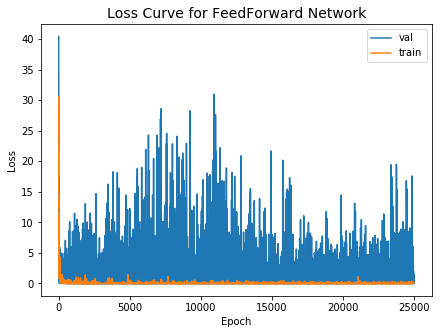

In [102]:
fig = plt.figure(figsize=(7, 5))
plt.title("Loss Curve for FeedForward Network", fontsize=14)
plt.plot(vlosses_12, label="val")
plt.plot(losses_12, label="train")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
fig.savefig("./images/ffsm_performance.pdf", bbox_inches='tight')

# Testing on the Test Set

In [103]:
# Indicated by maximum energy

total = y_test.shape[0]
correct = 0

for i in range(X_test.shape[0]):
    data = X_test[i, :, :].flatten()
    #print(data)
    data = torch.from_numpy(data).float().cuda()
    true_out = y_test[i, :]
    mdl_out = mdl1.forward(data)
    out = (mdl_out.data).cpu().numpy()
    if np.argmax(out) == np.argmax(true_out):
        correct += 1
print("Accuracy = ", correct*100/total)

Accuracy =  84.72222222222223
